# Imports

In [28]:
import numpy as np
import pandas as pd # 1.1
from sklearn.preprocessing import StandardScaler # 1.2
from sklearn.model_selection import train_test_split # 1.4
from torch.utils.data import DataLoader, Dataset

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# 1. Data Preprocessing

## 1.1 Get Data

### Player Data

In [30]:
player_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/nba_players.csv'
player_df = pd.read_csv(player_data_url)
player_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,mathcup,gamedate,winloss,minuters,pts,fgm,...,dreb,reb,ast,stl,blk,tov,pfo,plusminus,fp1,player
0,1710822472-1,https://www.nba.com/stats/players/boxscores,NaN,ATL,ATL @ LAL,03/18/2024,NaN,13,8,4,...,4,8,0,1,1,1,1,-7,22.6,Clint Capela
1,1710822472-2,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,19,8,3,...,3,4,3,2,2,1,2,-1,28.3,Mo Bamba
2,1710822472-3,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,16,11,4,...,1,2,1,1,1,0,1,1,20.9,Thomas Bryant
3,1710822472-4,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,32,20,8,...,10,13,6,0,0,4,1,-19,40.6,Bam Adebayo
4,1710822472-5,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,24,12,4,...,1,2,1,0,1,1,1,11,17.9,Buddy Hield


In [31]:
player_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'mathcup', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'fp1', 'player'],
      dtype='object')

In [32]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage', 'fp1']
player_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
player_df['gamedate'] = pd.to_datetime(player_df['gamedate'])
player_df = player_df[player_df['gamedate'] != '2024-03-18']

# NBA made a typo so we gotta fix that
player_df['matchup'] = player_df['mathcup']
player_df.drop(columns=['mathcup'], inplace=True)

In [33]:
def calculate_fantasy_points(row):
    # Points scored
    points_scored = row['pts'] * 0.5
    # Rebounds, Assists, Steals, and Blocks
    rebound_points = (row['oreb'] + row['dreb']) * 1
    assist_points = row['ast'] * 1
    steal_points = row['stl'] * 2
    block_points = row['blk'] * 2
    # Turnovers
    turnover_points = row['tov'] * -1
    # Three-points made
    three_points = row['3pm'] * 0.5
    # Double-Double and Triple-Double
    double_digits = sum(i >= 10 for i in [row['pts'], row['oreb'] + row['dreb'], row['ast'], row['stl'], row['blk']])
    double_double_points = 1.0 if double_digits >= 2 else 0
    triple_double_points = 2.0 if double_digits >= 3 else 0
    # 40+ and 50+ bonuses
    fourty_pt_bonus = 2.0 * (row['pts'] >= 40)
    fifty_pt_bonus = 2.0 * (row['pts'] >= 50)
    # Total fantasy points
    total_points = (points_scored + rebound_points + assist_points +
                    steal_points + block_points + turnover_points + three_points +
                    double_double_points + triple_double_points +
                    fourty_pt_bonus + fifty_pt_bonus)
    return total_points

In [34]:
def get_opp_team(matchup):
    if '@' in matchup:
        return matchup.split(' @ ')[1]
    elif 'vs.' in matchup:
        return matchup.split(' vs. ')[1]
    else:
        return None

In [35]:
# Helper function to determine home and away teams
def extract_teams(matchup):
    teams_a = matchup.split(' @ ')
    teams_h = matchup.split(' vs. ')
    if '@' in matchup:
        return teams_a[1], teams_a[0]
    else:
        return teams_h[0], teams_h[1]

# Function to create game_id
def create_game_id(row):
    home_team, away_team = extract_teams(row['matchup'])
    game_date = row['gamedate'].strftime('%Y-%m-%d')
    return f"{home_team}.{away_team}.{game_date}"

In [36]:
player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L
player_df['fp'] = player_df.apply(calculate_fantasy_points, axis=1) # calculate fantasy points
player_df['opp_team'] = player_df['matchup'].apply(get_opp_team) # extract the opponent team name
player_df['game_id'] = player_df.apply(create_game_id, axis=1) # calculate the game id

# calculate how many days has passed since the start of the season till this game
season_start_date = pd.Timestamp('2023-10-24')
player_df['days_since'] = (player_df['gamedate'] - season_start_date).dt.days

player_df.head()

,team,gamedate,winloss,minuters,pts,fgm,fga,fgpercent,3pm,3pa,...,tov,pfo,plusminus,player,matchup,is_home,fp,opp_team,game_id,days_since
152,BOS,2024-03-17,1,35,14,6,15,40.0,2,5,...,1,0,16,Payton Pritchard,BOS @ WAS,0,28.0,WAS,WAS.BOS.2024-03-17,145
153,BOS,2024-03-17,1,23,9,3,7,42.9,3,6,...,0,0,7,Svi Mykhailiuk,BOS @ WAS,0,13.0,WAS,WAS.BOS.2024-03-17,145
154,BOS,2024-03-17,1,20,14,5,9,55.6,0,0,...,1,1,9,Luke Kornet,BOS @ WAS,0,17.0,WAS,WAS.BOS.2024-03-17,145
155,WAS,2024-03-17,0,22,8,4,7,57.1,0,2,...,0,3,-17,Johnny Davis,WAS vs. BOS,1,13.0,BOS,WAS.BOS.2024-03-17,145
156,WAS,2024-03-17,0,15,0,0,1,0.0,0,1,...,1,2,-14,Eugene Omoruyi,WAS vs. BOS,1,3.0,BOS,WAS.BOS.2024-03-17,145


In [37]:
player_df.columns

Index(['team', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'player', 'matchup', 'is_home', 'fp', 'opp_team', 'game_id',
       'days_since'],
      dtype='object')

### Team Data

In [38]:
team_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/teamscores.csv'
team_df = pd.read_csv(team_data_url)

In [39]:
team_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,matchup,date,winloss,min,pts,fgm,...,ftpercent,oreb,dreb,reb,ast,stl,blk,tov,pfidk,plusminus
0,1710880555-1,https://www.nba.com/stats/teams/boxscores,NaN,CLE,CLE @ IND,03/18/2024,W,240,108,38,...,71.4,9,30,39,27,8,4,14,18,5
1,1710880555-2,https://www.nba.com/stats/teams/boxscores,NaN,IND,IND vs. CLE,03/18/2024,L,240,103,42,...,62.5,14,31,45,28,8,3,11,24,-5
2,1710880555-3,https://www.nba.com/stats/teams/boxscores,NaN,DET,DET @ BOS,03/18/2024,L,240,94,36,...,86.7,8,35,43,21,6,3,13,15,-25
3,1710880555-4,https://www.nba.com/stats/teams/boxscores,NaN,BOS,BOS vs. DET,03/18/2024,W,240,119,43,...,84.6,15,38,53,30,8,8,11,9,25
4,1710880555-5,https://www.nba.com/stats/teams/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,240,98,37,...,91.7,7,39,46,23,7,12,12,16,7


In [40]:
team_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'matchup', 'date', 'winloss', 'min', 'pts', 'fgm', 'fga', 'fgpercent',
       '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'tov', 'pfidk', 'plusminus'],
      dtype='object')

In [41]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage']
team_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
team_df['gamedate'] = pd.to_datetime(team_df['date'])
team_df = team_df[team_df['gamedate'] != '2024-03-18']

In [42]:
team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
team_df['game_id'] = team_df.apply(create_game_id, axis=1)
team_df.head()

,team,matchup,date,winloss,min,pts,fgm,fga,fgpercent,3pm,...,ast,stl,blk,tov,pfidk,plusminus,gamedate,is_home,opp_team,game_id
16,LAC,LAC vs. ATL,03/17/2024,L,240,93,28,74,37.8,11,...,17,10,5,16,13,-17,2024-03-17,1,ATL,LAC.ATL.2024-03-17
17,ATL,ATL @ LAC,03/17/2024,W,240,110,41,84,48.8,17,...,32,10,7,16,22,17,2024-03-17,0,LAC,LAC.ATL.2024-03-17
18,BKN,BKN @ SAS,03/17/2024,L,265,115,47,102,46.1,8,...,29,13,5,12,20,-7,2024-03-17,0,SAS,SAS.BKN.2024-03-17
19,SAS,SAS vs. BKN,03/17/2024,W,265,122,46,99,46.5,9,...,30,6,10,18,17,7,2024-03-17,1,BKN,SAS.BKN.2024-03-17
20,ORL,ORL vs. TOR,03/17/2024,W,240,111,43,85,50.6,11,...,22,7,4,15,16,15,2024-03-17,1,TOR,ORL.TOR.2024-03-17


### Merging

In [43]:
own_team_df = team_df.copy()
opp_team_df = team_df.copy()

In [44]:
# renaming columns for the team data
team_rename_columns = {
    'pts': 'team_pts',
    'fgm': 'team_fgm',
    'fga': 'team_fga',
    'fgpercent': 'team_fgpercent',
    '3pm': 'team_3pm',
    '3pa': 'team_3pa',
    '3ppercent': 'team_3ppercent',
    'ftm': 'team_ftm',
    'fta': 'team_fta',
    'ftpercent': 'team_ftpercent',
    'oreb': 'team_oreb',
    'dreb': 'team_dreb',
    'reb': 'team_reb',
    'ast': 'team_ast',
    'stl': 'team_stl',
    'blk': 'team_blk',
    'tov': 'team_tov',
    'pfidk': 'team_pfidk',
    'plusminus': 'team_plusminus'
}

# renaming columns for the opponent team data
opp_rename_columns = {
    'pts': 'opp_pts',
    'fgm': 'opp_fgm',
    'fga': 'opp_fga',
    'fgpercent': 'opp_fgpercent',
    '3pm': 'opp_3pm',
    '3pa': 'opp_3pa',
    '3ppercent': 'opp_3ppercent',
    'ftm': 'opp_ftm',
    'fta': 'opp_fta',
    'ftpercent': 'opp_ftpercent',
    'oreb': 'opp_oreb',
    'dreb': 'opp_dreb',
    'reb': 'opp_reb',
    'ast': 'opp_ast',
    'stl': 'opp_stl',
    'blk': 'opp_blk',
    'tov': 'opp_tov',
    'pfidk': 'opp_pfidk',
    'plusminus': 'opp_plusminus'
}

own_team_df.rename(columns=team_rename_columns, inplace=True)
opp_team_df.rename(columns=opp_rename_columns, inplace=True)

In [45]:
opp_team_df.columns

Index(['team', 'matchup', 'date', 'winloss', 'min', 'opp_pts', 'opp_fgm',
       'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent',
       'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb', 'opp_dreb',
       'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov', 'opp_pfidk',
       'opp_plusminus', 'gamedate', 'is_home', 'opp_team', 'game_id'],
      dtype='object')

In [46]:
# merging player data with own team data
initial_merged_df = pd.merge(player_df, own_team_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from team_df that are redundant
initial_merged_df.drop([col for col in initial_merged_df.columns if 'drop' in col], axis=1, inplace=True)

# merging the last df with opponent team data
df = pd.merge(initial_merged_df, opp_team_df, left_on=['game_id', 'opp_team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from opp_team_df that are redundant
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)

In [47]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'opp_team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'opp_team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_oreb,opp_dreb,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,10,30,40,24,3,5,16,20,-26,28.0
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,10,30,40,24,3,5,16,20,-26,13.0
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,10,30,40,24,3,5,16,20,-26,17.0
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,10,30,40,24,3,5,16,20,-26,29.0
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,10,30,40,24,3,5,16,20,-26,1.0


In [48]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

## 1.2 Z-Score Normalization / Standardization

In [49]:
"""
# Select the columns with player stats
stats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here

# Initialize the scaler
scaler = StandardScaler()

# Normalize the stats using Z-score normalization
df[stats_columns] = scaler.fit_transform(df[stats_columns])
"""

"\n# Select the columns with player stats\nstats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here\n\n# Initialize the scaler\nscaler = StandardScaler()\n\n# Normalize the stats using Z-score normalization\ndf[stats_columns] = scaler.fit_transform(df[stats_columns])\n"

## 1.25: EXPERIMENTAL REMOVING OF MORE COLUMNS TO SIMPLIFY THE MODEL

In [50]:
# EXPERIMENTAL:
more_columns_to_remove = \
 ['opp_team', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent', 'ftm',
  'fta', 'ftpercent', 'pfo', 'plusminus', 'matchup', 'is_home', 'date', 'min',
  'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm', 'team_3pa',
  'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent', 'team_oreb',
  'team_dreb', 'team_reb', 'team_ast', 'team_stl', 'team_blk', 'team_tov',
  'team_pfidk', 'team_plusminus', 'opp_pts', 'opp_fgm', 'opp_fga',
  'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent', 'opp_ftm', 'opp_fta',
  'opp_ftpercent', 'opp_oreb', 'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl',
  'opp_blk', 'opp_tov', 'opp_pfidk', 'opp_plusminus']
df.drop(columns=more_columns_to_remove, inplace=True)

In [51]:
df.columns

Index(['player', 'team', 'gamedate', 'days_since', 'winloss', 'minuters',
       'pts', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'game_id',
       'fp'],
      dtype='object')

## 1.275: EXPERIMENTAL REMOVING OF PLAYERS THAT HAVENT PLAYED 10 GAMES AND THAT ARE NOT IN TOP 150

In [76]:
# Filter out players who have played less than 10 games
game_counts = df['player'].value_counts()
players_at_least_10_games = game_counts[game_counts >= 10].index
filtered_df = df[df['player'].isin(players_at_least_10_games)]

# Compute season average fantasy points for each player
season_averages = filtered_df.groupby('player')['fp'].mean().reset_index().sort_values(by='fp', ascending=False)

# Keep only the top 150 players in terms of season average
top_players = season_averages.head(150)['player']
simple_df = filtered_df[filtered_df['player'].isin(top_players)]

## 1.3 One-Hot Encoding

In [ ]:
# one-hot encode the categorical columns
#df = pd.get_dummies(df, columns=['opp_team'])

In [ ]:
## reorder the columns for visual purposes
columns_order = ['player', 'team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'gamedate', 'days_since', 'fp']] + ['fp']
#df = df[columns_order]

In [52]:
df.head()

,player,team,gamedate,days_since,winloss,minuters,pts,oreb,dreb,reb,ast,stl,blk,tov,game_id,fp
0,Payton Pritchard,BOS,2024-03-17,145,1,35,14,2,3,5,13,1,0,1,WAS.BOS.2024-03-17,28.0
1,Svi Mykhailiuk,BOS,2024-03-17,145,1,23,9,0,5,5,2,0,0,0,WAS.BOS.2024-03-17,13.0
2,Luke Kornet,BOS,2024-03-17,145,1,20,14,3,3,6,1,0,2,1,WAS.BOS.2024-03-17,17.0
3,Sam Hauser,BOS,2024-03-17,145,1,23,30,0,6,6,1,1,0,0,WAS.BOS.2024-03-17,29.0
4,Neemias Queta,BOS,2024-03-17,145,1,8,0,0,2,2,0,0,0,1,WAS.BOS.2024-03-17,1.0


In [53]:
df.columns

Index(['player', 'team', 'gamedate', 'days_since', 'winloss', 'minuters',
       'pts', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'game_id',
       'fp'],
      dtype='object')

## 1.4 Split per player



In [108]:
from torch.utils.data import Dataset, DataLoader
import torch

class NBAFantasyDataset(Dataset):
    def __init__(self, dataframe, num_games=10):
        """
        Initialize the dataset with a dataframe.
        Each row in the dataframe corresponds to a game by a player.
        :param dataframe: pandas DataFrame containing the data.
        :param num_games: int, number of recent games to consider.
        """
        self.num_games = num_games
        self.data = dataframe

        # Filter out players with fewer than `num_games` games played
        player_counts = self.data['player'].value_counts()
        eligible_players = player_counts[player_counts >= num_games].index
        self.data = self.data[self.data['player'].isin(eligible_players)]

        # Calculate the season average for the 'fp' column for eligible players
        self.season_avg_fp = self.data.groupby('player')['fp'].mean()

        # Keep a list of eligible players
        self.players = self.data['player'].unique()

    def __len__(self):
        return len(self.players)

    def __getitem__(self, idx):
        player_name = self.players[idx]

        # Get the season average 'fp' for this player
        season_avg_fp = self.season_avg_fp.loc[player_name]

        # Get all rows for this player and sort by date to get the most recent games
        player_data = self.data[self.data['player'] == player_name]
        player_data = player_data.sort_values('gamedate', ascending=False)

        # Get the last `num_games` for this player
        recent_games = player_data.iloc[:self.num_games]

        # Use only numeric columns for features, excluding identifiers and 'fp'
        numeric_cols = player_data.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols.remove('fp')  # We do not want to include the target in the features

        # Combine season average with recent games
        features = [season_avg_fp] + recent_games[numeric_cols].values.flatten().tolist()

        # Convert to tensor
        features_tensor = torch.tensor(features, dtype=torch.float)
        target_tensor = torch.tensor(recent_games.iloc[0]['fp'], dtype=torch.float)

        return features_tensor, target_tensor

In [84]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return torch.tensor([]), torch.tensor([])

    # Find the maximum number of rows in the feature tensors
    max_rows = max(features.shape[0] for features, _ in batch)

    # Pad feature tensors with zeros to match the maximum number of rows
    padded_features = [torch.nn.functional.pad(features, (0, 0, 0, max_rows - features.shape[0])) for features, _ in batch]

    # Stack the padded feature tensors and targets
    features_stack = torch.stack(padded_features)
    targets_stack = torch.stack([targets for _, targets in batch])

    return features_stack, targets_stack

In [85]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    features, targets = zip(*batch)
    features_padded = torch.nn.utils.rnn.pad_sequence(features, batch_first=True, padding_value=0)
    targets_stacked = torch.stack(targets)
    return features_padded, targets_stacked

In [102]:
non_feature_cols = ['player', 'team', 'gamedate', 'game_id', 'fp']
simple_df.drop(columns=non_feature_cols).head()

,days_since,winloss,minuters,pts,oreb,dreb,reb,ast,stl,blk,tov
21683,0,1,35,15,2,5,7,5,2,1,0
21174,3,1,30,10,1,1,2,3,3,1,1
20822,5,1,23,9,1,2,3,2,1,3,1
20586,6,1,33,21,3,4,7,2,0,0,3
20454,8,0,18,4,1,1,2,2,0,1,2


In [109]:
player_history_dataset = NBAFantasyDataset(simple_df)
dataloader = DataLoader(player_history_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [115]:
for batch_idx, (features, targets) in enumerate(dataloader):
    print(features)
    break

tensor([[ 37.6515, 145.0000,   0.0000,  ...,   3.0000,   1.0000,   2.0000],
        [ 15.9898, 145.0000,   1.0000,  ...,   0.0000,   2.0000,   0.0000],
        [ 18.7937, 142.0000,   0.0000,  ...,   0.0000,   1.0000,   3.0000],
        ...,
        [ 17.8333, 144.0000,   1.0000,  ...,   4.0000,   0.0000,   2.0000],
        [ 15.7778, 145.0000,   0.0000,  ...,   1.0000,   1.0000,   4.0000],
        [ 34.4609, 144.0000,   0.0000,  ...,   3.0000,   2.0000,   3.0000]])


## 1.5 Train-Test Split

In [104]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Create datasets and dataloaders for train and test sets
train_dataset = NBAFantasyDataset(train_df)
test_dataset = NBAFantasyDataset(test_df)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [95]:
num_players_zero_fp = df[df['fp'] == 0]['player']
total_players_zero_fp = df[df['fp'] >= -10000]['player']
print(f"Number of players with zero fantasy points: {num_players_zero_fp}")
print(f"Total players with zero fantasy points: {total_players_zero_fp}")

Number of players with zero fantasy points: 14473        A.J. Lawson
13736        A.J. Lawson
13082        A.J. Lawson
5239         A.J. Lawson
4599         A.J. Lawson
              ...       
9543          Zeke Nnaji
621           Zeke Nnaji
15140    Ziaire Williams
11425    Ziaire Williams
11155    Ziaire Williams
Name: player, Length: 950, dtype: object
Total players with zero fantasy points: 15715        A.J. Lawson
15554        A.J. Lawson
15312        A.J. Lawson
15004        A.J. Lawson
14728        A.J. Lawson
              ...       
1427     Zion Williamson
1166     Zion Williamson
611      Zion Williamson
379      Zion Williamson
332      Zion Williamson
Name: player, Length: 21695, dtype: object


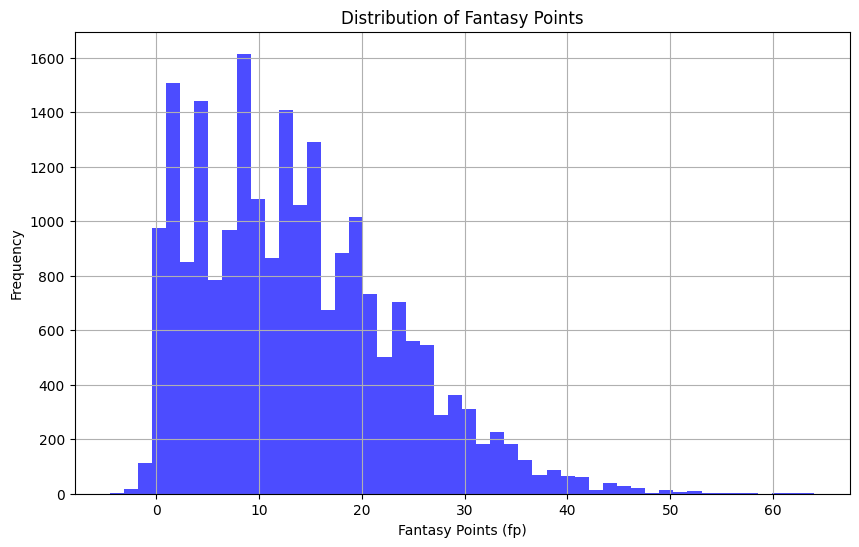

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'fp' is the column with fantasy points
plt.figure(figsize=(10, 6))
plt.hist(df['fp'], bins=50, alpha=0.7, color='blue')
plt.xlabel('Fantasy Points (fp)')
plt.ylabel('Frequency')
plt.title('Distribution of Fantasy Points')
plt.grid(True)
plt.show()

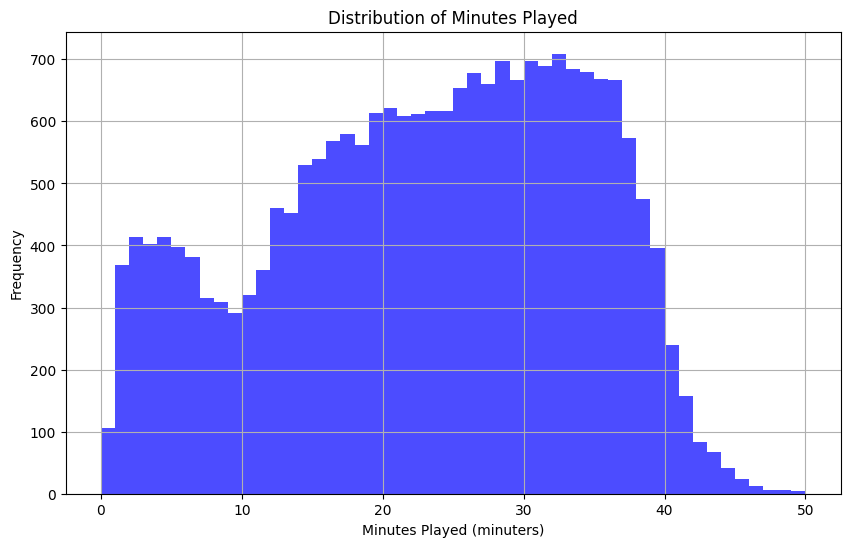

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'fp' is the column with fantasy points
plt.figure(figsize=(10, 6))
plt.hist(df['minuters'], bins=50, alpha=0.7, color='blue')
plt.xlabel('Minutes Played (minuters)')
plt.ylabel('Frequency')
plt.title('Distribution of Minutes Played')
plt.grid(True)
plt.show()

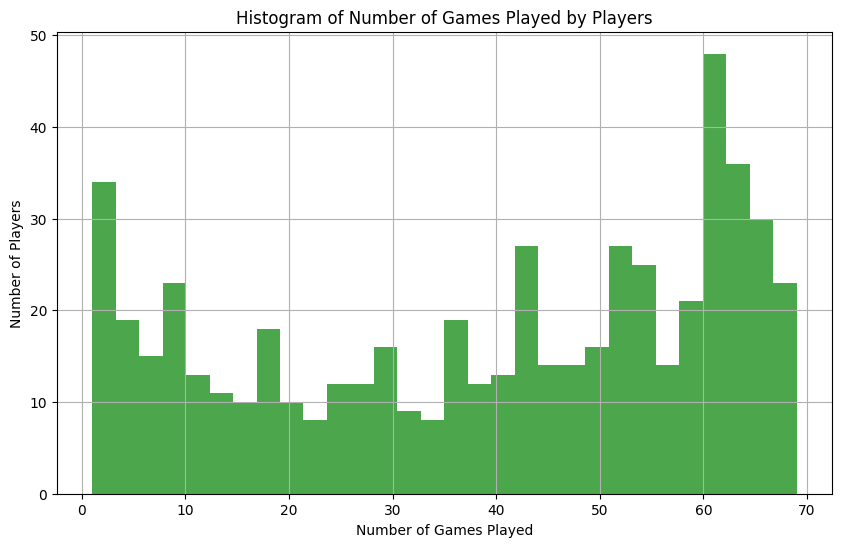

In [ ]:
# Count the number of games played by each player
games_played_by_player = df['player'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(games_played_by_player, bins=30, alpha=0.7, color='green')
plt.xlabel('Number of Games Played')
plt.ylabel('Number of Players')
plt.title('Histogram of Number of Games Played by Players')
plt.grid(True)
plt.show()

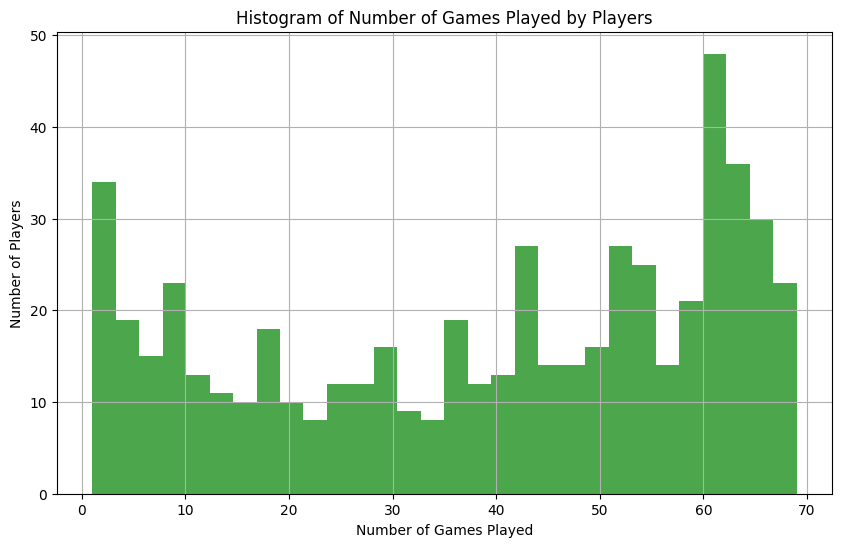

In [ ]:
from collections import Counter

# Count the number of games for each player using the NBAFantasyDataset
dataset = NBAFantasyDataset(df)
player_game_counts = Counter(dataset.data['player'])

# Convert the counts to a list for plotting
games_played = list(player_game_counts.values())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(games_played, bins=30, alpha=0.7, color='green')
plt.xlabel('Number of Games Played')
plt.ylabel('Number of Players')
plt.title('Histogram of Number of Games Played by Players')
plt.grid(True)
plt.show()


In [ ]:
print(np.median(df['fp']))

12.5


## 2.1 Baseline model building



In [59]:
import torch
import torch.nn as nn
import torch.optim as optim

In [116]:
class BaselineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.5):
        super(BaselineRNN, self).__init__()
        # Use LSTM instead of RNN
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        # An additional fully connected layer
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        # Output layer
        self.fc2 = nn.Linear(hidden_size, output_size)
        # Non-linearity
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        # x shape: (batch_size, seq_length, input_size)
        output, _ = self.lstm(x, (h0, c0))
        # Take the output of the last time step
        last_output = output[:, -1, :]
        # Additional fully connected layer with ReLU activation
        fc1_output = self.relu(self.fc1(last_output))
        # Final output layer
        output = self.fc2(fc1_output)
        return output

In [119]:
# Define the model
input_size = 101  # Number of features (excluding 'player', 'team', 'gamedate', 'fp')
hidden_size = 64  # Can be adjusted
output_size = 1  # Predicting 'fp'

model = BaselineRNN(input_size, hidden_size, output_size)
print(model)

BaselineRNN(
  (lstm): LSTM(101, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [124]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20  # Can be adjusted
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (features, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        if features.size(0) == 1:
            features = features.squeeze(0).unsqueeze(1)
        outputs = model(features)
        # Ensure targets and outputs have the same shape
        loss = criterion(outputs.squeeze(-1), targets.squeeze(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader)}')

Epoch 1/20, Loss: 41.36632776260376
Epoch 2/20, Loss: 36.31632614135742
Epoch 3/20, Loss: 36.86729303995768
Epoch 4/20, Loss: 37.143126805623375
Epoch 5/20, Loss: 32.28925275802612
Epoch 6/20, Loss: 34.50414307912191
Epoch 7/20, Loss: 33.79826251665751
Epoch 8/20, Loss: 30.58988920847575
Epoch 9/20, Loss: 31.06751545270284
Epoch 10/20, Loss: 32.53540245691935
Epoch 11/20, Loss: 30.763002316157024
Epoch 12/20, Loss: 22.051037311553955
Epoch 13/20, Loss: 25.297903299331665
Epoch 14/20, Loss: 25.704890807469685
Epoch 15/20, Loss: 30.37185001373291
Epoch 16/20, Loss: 21.88066037495931
Epoch 17/20, Loss: 24.79802481333415
Epoch 18/20, Loss: 26.379634857177734
Epoch 19/20, Loss: 25.49437626202901
Epoch 20/20, Loss: 23.610562245051067


In [99]:
l=0
for batch_idx, (features, targets) in enumerate(train_dataloader):
    l = len(features)
    print(l)

32
32
32
32
32
32
32
32
32
32
32
22


In [73]:
num_epochs = 100  # Can be adjusted
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (features, targets) in enumerate(train_dataloader):
        for f in features[0]:
            print(f)
        #print(targets[0])
        break
    break

tensor([8., 0., 6., 4., 0., 2., 2., 1., 0., 0., 1.])
tensor([13.,  0., 11.,  0.,  0.,  3.,  3.,  0.,  0.,  0.,  0.])
tensor([17.,  0.,  7.,  6.,  3.,  1.,  4.,  0.,  0.,  0.,  0.])
tensor([19.,  0., 14.,  6.,  1.,  1.,  2.,  0.,  1.,  2.,  2.])
tensor([21.,  0., 14., 11.,  1.,  3.,  4.,  1.,  0.,  0.,  0.])
tensor([24.,  0.,  4.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [122]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for features, targets in dataloader:
            outputs = model(features)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    return mse, rmse, mae, r2

# Evaluate the model on the test set
mse, rmse, mae, r2 = evaluate_model(model, test_dataloader)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 43.81243032673124
Root Mean Squared Error: 6.619095884388686
Mean Absolute Error: 4.95519479115804
R-squared: 0.5430125686104095


In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20  # Can be adjusted
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (features, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        if features.size(0) == 1:
            features = features.squeeze(0).unsqueeze(1)
        outputs = model(features)
        # Ensure targets and outputs have the same shape
        loss = criterion(outputs.squeeze(-1), targets.squeeze(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader)}')

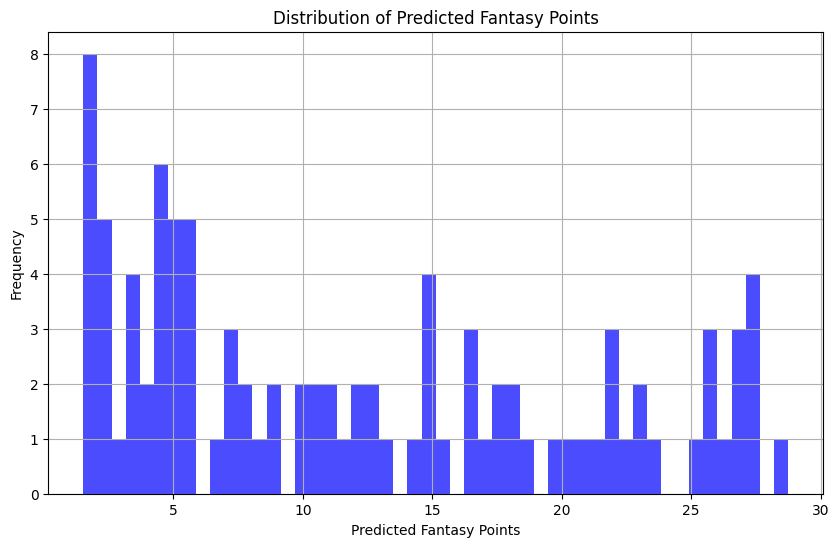

Accuracy: 0.75


In [142]:
import matplotlib.pyplot as plt
def calculate_accuracy_and_plot_distribution(model, data_loader, threshold=5.0):
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0
    predictions_list = []  # List to store predictions

    with torch.no_grad():  # No need to track gradients during evaluation
        for features, targets in data_loader:
            if features.size(0) == 1:
                features = features.squeeze(0).unsqueeze(1)

            predictions = model(features)
            predictions_list.append(predictions.cpu().numpy())  # Store predictions
            total += targets.size(0)

            # Count how many predictions fall within +/- threshold of the targets
            correct += torch.sum(torch.abs(predictions - targets) <= threshold)

    accuracy = correct / total
    accuracy_value = accuracy.item()  # Convert from tensor to a scalar

    # Plot the distribution of predicted fantasy points
    plt.figure(figsize=(10, 6))
    plt.hist(np.concatenate(predictions_list), bins=50, alpha=0.7, color='blue')
    plt.xlabel('Predicted Fantasy Points')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Fantasy Points')
    plt.grid(True)
    plt.show()

    return accuracy_value

# Example usage:
threshold = 5.0  # Define a threshold
accuracy = calculate_accuracy_and_plot_distribution(model, test_dataloader, threshold)
print(f'Accuracy: {accuracy:.2f}')

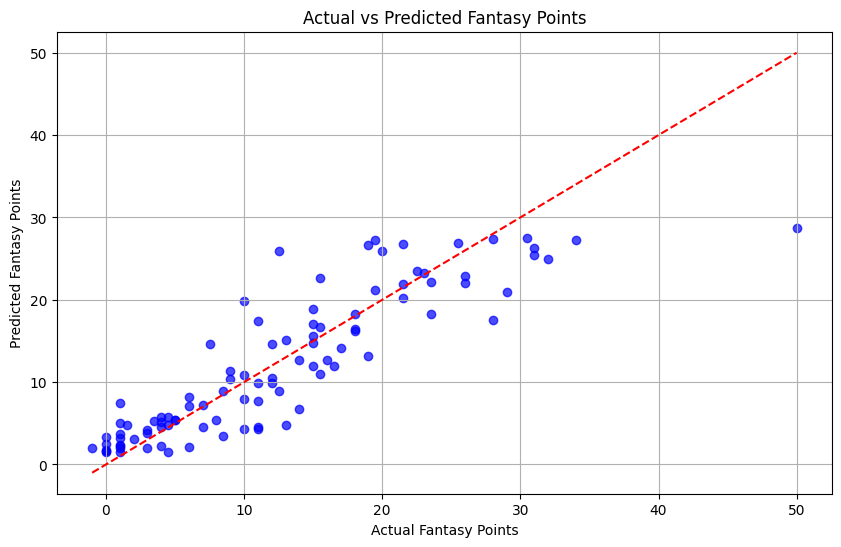

In [143]:
def plot_actual_vs_predicted(model, data_loader):
    model.eval()  # Set the model to evaluation mode

    actual_list = []  # List to store actual values
    predicted_list = []  # List to store predicted values

    with torch.no_grad():  # No need to track gradients during evaluation
        for features, targets in data_loader:
            if features.size(0) == 1:
                features = features.squeeze(0).unsqueeze(1)

            predictions = model(features).view(-1)
            predicted_list.extend(predictions.cpu().numpy())  # Store predictions
            actual_list.extend(targets.cpu().numpy())  # Store actual values

    # Plot actual vs predicted fantasy points
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_list, predicted_list, alpha=0.7, color='blue')
    plt.xlabel('Actual Fantasy Points')
    plt.ylabel('Predicted Fantasy Points')
    plt.title('Actual vs Predicted Fantasy Points')
    plt.grid(True)
    plt.plot([min(actual_list), max(actual_list)], [min(actual_list), max(actual_list)], 'r--')  # Diagonal line for reference
    plt.show()

# Example usage:
plot_actual_vs_predicted(model, test_dataloader)